## Equation Discovery (first attempt + guide notebook)

Author: Antony Sikorski 

My attempt at rediscovering the parameterization equation for pressure redistribution using high resolution, Large Eddy Simulation (LES) data. 

First, importing necessary libraries: 
- xarray, netcdf, and h5 are all for the data
- PySR is for symbolic regression (equation discovery). Github: https://github.com/MilesCranmer/PySR

In [15]:
import pysr
from pysr import PySRRegressor

import xarray as xr
import netCDF4 as nc
import h5netcdf

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

---
### Part 1: Data Exploration


Data is in netcdf file format. Files are named according to certain initial conditions that are set: 

- Ug: Imposed wind (large scale wind, geostrophic)
- Q: Surface heating (how much heat you're putting into your domain, initially affects the surface level)
- SI/WI: Strong/Weak Inversion (talking about the temperature inversion that occurs at the top of the ABL, will be visible when looking at the gradient of $\Theta$)

In this notebook, we will open two similar files: 

In [16]:
# all of my LES files are currently stored here
folder_path = 'C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim'

file_path_1 = 'Ug2Q024_WI.nc'
file_path_2 = 'Ug2Q024_SI.nc' # strong inversion

df_1 = nc.Dataset(folder_path + '/' + file_path_1, mode='r')
df_2 = nc.Dataset(folder_path + '/' + file_path_2, mode='r')

df_1

# #closing netCDF files since we extracted the data 
# df_1.close()
# df_2.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget

There are three groups which contain different variables: `default`, `thermo`, and `budget`. Typically the temperature terms are found in `thermo` etc. Variables in these groups will have values across two dimensions. 

One of the dimensions is always `time`. Depending on the variables, the other dimensions (height), will either be `z` or `zh`, because some variables are calculated at the center of a cell, other variables are calculate on the surfaces
This is due to the nature of "MicroHH", which is the CFD model we used for simulation. MicroHH is discretized on a staggered Arakawa C-grid, where the scalars are located in the center of a grid cell and the three velocity components are at the faces. Source code for this CFD model: https://github.com/microhh/microhh/tree/main/src

For this dataset, `time` has length 120 (minutes) because there are 2 hours of data. The LES is actually run for 4 hours, but the first two are chopped off. 

The resolution of our LES is $24 \times 24 \times 6$ $ m^3$. I think the variables we get are a result of averaging in the horizontal plane, thus we only retain a height (`z` or `zh`) variable. Let's take a look at all of the variables: 

In [17]:
for group_name, group in df_2.groups.items():
    print(f"Group: {group_name}")
    for var_name, var in group.variables.items():
        long_name = var.getncattr('long_name') if 'long_name' in var.ncattrs() else 'No long_name attribute'
        dimensions = var.dimensions if hasattr(var, 'dimensions') else 'No dimensions attribute'
        print(f"  Variable: {var_name},  Long Name: {long_name},  Dimensions: {dimensions}")

Group: default
  Variable: iter,  Long Name: Iteration number,  Dimensions: ('time',)
  Variable: area,  Long Name: Fractional area contained in mask,  Dimensions: ('time', 'z')
  Variable: areah,  Long Name: Fractional area contained in mask,  Dimensions: ('time', 'zh')
  Variable: eft,  Long Name: eft,  Dimensions: ('time', 'z')
  Variable: eft_3,  Long Name: Moment 3 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_4,  Long Name: Moment 4 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_diff,  Long Name: Diffusive flux of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_w,  Long Name: Turbulent flux of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_grad,  Long Name: Gradient of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_2,  Long Name: Moment 2 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_path,  Long Name: eft path,  Dimensions: ('time',)
  Variable: eft_flux,  Long Name: Total flux of the eft,  Dimensions: ('time', 'zh')
  Variable: sft,  Lo

Let's take a look at some key variables, and try to recreate the figures in *"The non-local character of turbulence asymmetry in the convective atmospheric boundary layer" by Ghannam et al*. Link: https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.2937

We will initially focus on $\Theta$, $\frac{\mathrm{d}\Theta}{\mathrm{d}z}$, and $\overline{w' \theta'}$, which are mean potential temperature, its vertical gradient, and then turbulent heat flux, respectively. 

In [18]:
#extract variables from both df, name accordingly
Theta_WI = df_1.groups['thermo'].variables['th']
dTheta_dz_WI = df_1.groups['thermo'].variables['th_grad']
w_theta_WI = df_1.groups['thermo'].variables['th_flux']

Theta_SI = df_2.groups['thermo'].variables['th']
dTheta_dz_SI = df_2.groups['thermo'].variables['th_grad']
w_theta_SI = df_2.groups['thermo'].variables['th_flux']

# couldn't think of how to extract z, zh, t any better so I just did this. 
# someone please do this better 
z = xr.DataArray(Theta_WI, dims=Theta_WI.dimensions)['z'].values
assert(len(z) == 256)
zh = xr.DataArray(w_theta_WI, dims=w_theta_WI.dimensions)['zh'].values
assert(len(zh) == 257)
t = xr.DataArray(Theta_WI, dims=Theta_WI.dimensions)['time'].values
assert(len(t) == 120)

First we look at the unnormalized weak inversion plots of these three key variables:

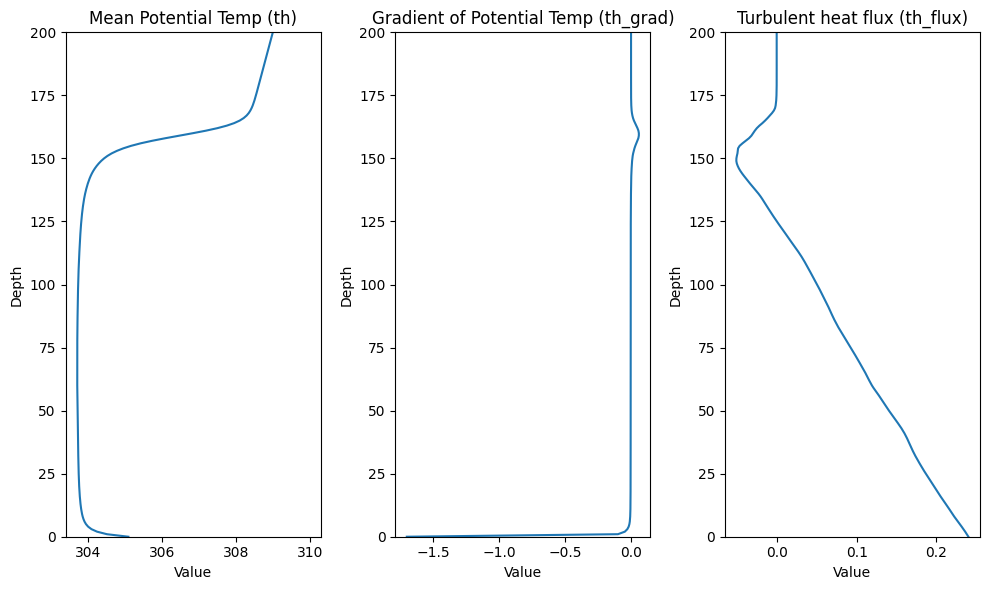

In [19]:
#pick a time at which to plot
timeStep = 60

#pick 'strong' or 'weak' inversion
inversion = 'weak' 

if inversion == 'strong':
    Theta = Theta_SI
    dTheta_dz = dTheta_dz_SI
    w_theta = w_theta_SI
if inversion == 'weak':
    Theta = Theta_WI
    dTheta_dz = dTheta_dz_WI
    w_theta = w_theta_WI

plt.figure(figsize = (10, 6))

# Plot potentialTemp
plt.subplot(1, 3, 1)
plt.plot(Theta[timeStep], np.arange(0, 256))
plt.ylim(0, 200)
plt.title('Mean Potential Temp (th)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 3, 2)
plt.plot(dTheta_dz[timeStep], np.arange(0, 257))
plt.ylim(0, 200)
plt.title('Gradient of Potential Temp (th_grad)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 3, 3)
plt.plot(w_theta[timeStep], np.arange(0, 257))
plt.ylim(0, 200)
plt.title('Turbulent heat flux (th_flux)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Show the plot
plt.tight_layout()
plt.show()

Normalizing the variables following the paper mentioned above in order to get more similar plots. We will use the weak inversion data. This normalization is definitely wrong at the moment. 

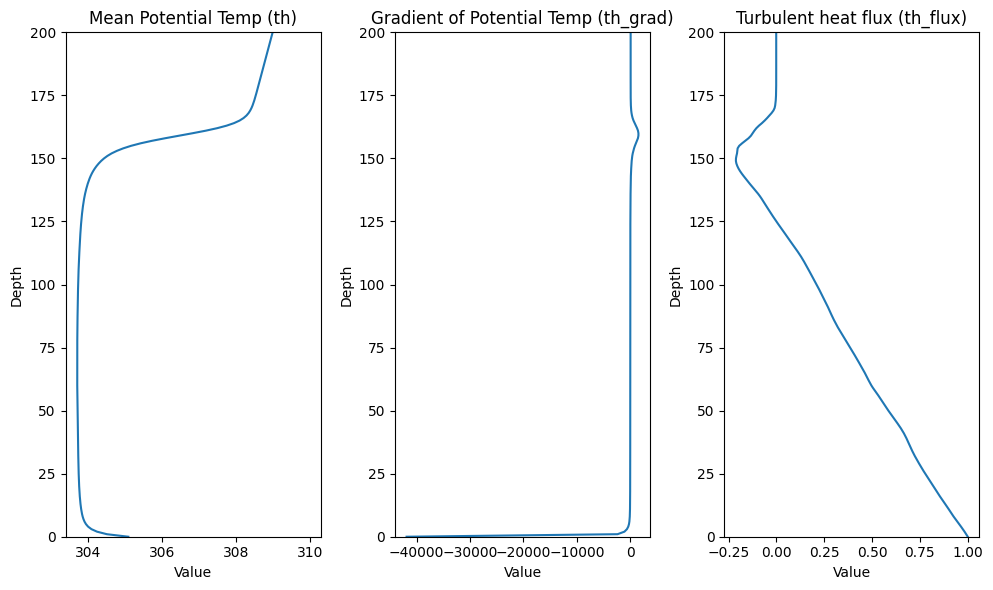

In [20]:
# not quite sure how to get this, setting to one for now
beta = 1

#boundary layer height (changes with time??)
h = df_1.groups['thermo'].variables['zi'][:]
h = h[timeStep]
h

#surface heat flux (i think)?
w_theta_0 = df_1.groups['thermo'].variables['th_flux'][timeStep][0]

plt.figure(figsize = (10, 6))

# Plot potentialTemp
plt.subplot(1, 3, 1)
plt.plot(Theta[timeStep], np.arange(0, 256))
plt.ylim(0, 200)
plt.title('Mean Potential Temp (th)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 3, 2)
plt.plot((dTheta_dz[timeStep] * h * np.cbrt(beta * w_theta_0 * h))/w_theta_0,
         np.arange(0, 257))
plt.ylim(0,200)
# plt.ylim(2, 200)
# plt.xlim(-2000, 2000)
plt.title('Gradient of Potential Temp (th_grad)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 3, 3)
plt.plot(w_theta[timeStep]/w_theta_0,
         np.arange(0, 257))
plt.ylim(0, 200)
plt.title('Turbulent heat flux (th_flux)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Show the plot
plt.tight_layout()
plt.show()

The gradient looks a little funky. Let's manually calculate the gradient and compare: 

Text(0, 0.5, 'Depth')

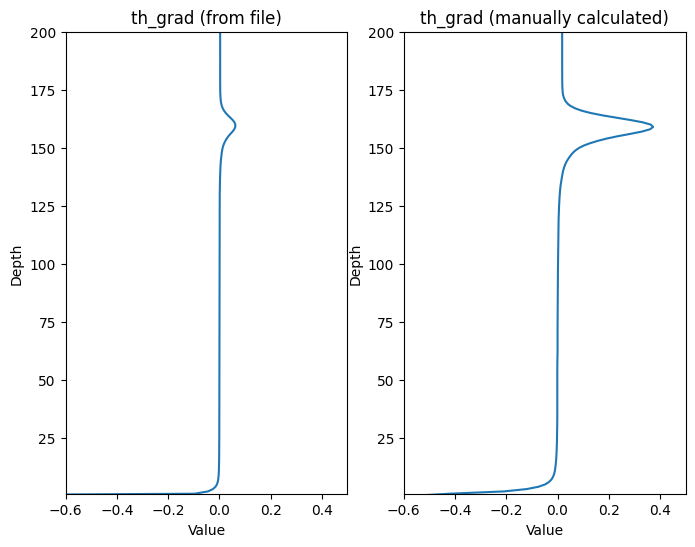

In [21]:
manualGrad = np.gradient(Theta[timeStep], z)

# #finite difference by hand
# manualGrad = np.zeros_like(poTemp)
# poTemp = Theta[timeStep]
# for i in range(1, len(poTemp)-1):
#     manualGrad[i] = (poTemp[i+1] - poTemp[i-1]) / (z[i+1] - z[i-1])

# # Handle the boundaries with forward and backward differences
# manualGrad[0] = (poTemp[1] - poTemp[0]) / (z[1] - z[0])
# manualGrad[-1] = (poTemp[-1] - poTemp[-2]) / (z[-1] - z[-2])

plt.figure(figsize = (8, 6))
plt.subplot(1, 2, 1)
plt.xlim(-0.6, 0.5)
plt.ylim(1, 200)
plt.plot(dTheta_dz[timeStep], np.arange(0, 257))
plt.title('th_grad (from file)')
plt.xlabel('Value')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(manualGrad, z)
plt.xlim(-0.6, 0.5)
plt.ylim(1, 200)
plt.title('th_grad (manually calculated)')
plt.xlabel('Value')
plt.ylabel('Depth')

The gradients appear pretty different. Could be due to finite differencing. Ask about this later !

---
### Part 2: Symbolic Regression

Let's try some symbolic regression. In this experiment, we will take a slice of the atmosphere at some height value, and will feed in all of the time steps (120) data points. We will do this for both the SI and WI, and combine their vectors to give us a total of $240$ instances.

In [22]:
#just looking at the values of the variables

print(dTheta_dz[60, 162:175])
print(w_theta[60, 162:175])
print(Theta[60, 162:175])

[0.05169276 0.04250197 0.03315227 0.02485832 0.01805246 0.01317526
 0.00968971 0.00728376 0.00576774 0.00479018 0.00413746 0.00366434
 0.0033939 ]
[-0.02517356 -0.02194457 -0.01819676 -0.01482775 -0.01175328 -0.00888376
 -0.00611063 -0.00377189 -0.0022914  -0.00159467 -0.00118603 -0.00087939
 -0.00067289]
[307.49128255 307.74629436 307.945208   308.09435793 308.20267268
 308.28172424 308.33986251 308.38356507 308.41817153 308.44691261
 308.47173737 308.49372338 308.51408678]


We want to find an equation for the $P$ term using equation discovery. We think that we can use equation discovery to recover something more exciting for the coefficients $C_i$, where $i \in 1,2,3$. 

$P=-\frac{1}{\rho_0} \overline{\theta \frac{\mathrm{d} p}{\mathrm{~d} z}}=-C_1 \frac{\overline{w \theta}}{\tau_1}-C_2 \beta \overline{\theta^2}+C_3 \sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}$

Term breakdown: 

- $P$: Potential temperature covariance, representing the covariance between potential temperature fluctuations and another variable (often vertical velocity or buoyancy). Might be difference between bw_pres and bw_rdstr (look in source code and Stull pg 123 and Rotta model), but for now assuming it is bw_rdstr.  
- $\rho_0$: Reference density, a constant representing the mean density of the fluid (often air in atmospheric studies).
- $θ$: Potential temperature, which is the temperature a parcel of air would have if it were expanded or compressed adiabatically to a standard pressure.
- $\overline{\frac{\mathrm{d} p}{\mathrm{d} z}}$: Mean vertical gradient of pressure, indicating how the pressure changes with height.
- $C_1, C_2, C_3$: Empirical constants determined through observations or theoretical considerations.
- $\overline{w θ}$: Covariance of vertical velocity (w) and potential temperature (θ), representing the turbulent heat flux.
- $τ₁$: A timescale associated with the turbulence.
- $β$: Buoyancy parameter, often related to the stratification of the atmosphere.
- $\overline{θ^2}$: Variance of potential temperature fluctuations.
- $\sigma_w^2$: Variance of vertical velocity fluctuations.
- $\frac{\mathrm{d} \Theta}{\mathrm{d} z}$: Vertical gradient of the mean potential temperature.

Converting to code:

We don't need to worry about $\rho_0$, $\beta$ cuz they are constants. In code, the terms and variables are: 

- $P$: `bw_rdstr` 
- $\overline{w θ}$: `th_flux`
- $\tau_1$: Unsure (timescale)
- $\overline{θ^2}$: `th_2`
- $\sigma_w^2$: `w_2`
- $\mathrm{\Theta}$: `th` (we can get the derivative with finite differencing)

For the purposes of initial equation re-discovery, 

$$P=-C_1 \frac{\overline{w \theta}}{\tau_1}-C_2 \beta \overline{\theta^2}+C_3 \sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}$$ 
is equivalent to `bw_pres` = $ a * $`th_flux` $ + b * $`th_2` $ + c * $ `w_2` $*$ `th_grad`
, where $a,b,c$ are constants. 


In [23]:
#the ones that go from zh have the last value trimmed
#this is because zh goes from 0 to 256, but z goes from 0 to 255
#ravel them along the first dim (time) to be able to put them into an array for pysr

layer = 162

P_WI = df_1.groups['budget'].variables['bw_rdstr'][:, layer].ravel()
w_theta_WI = df_1.groups['thermo'].variables['th_flux'][:, layer].ravel()
theta_2_WI = df_1.groups['thermo'].variables['th_2'][:, layer].ravel()
sigma_w_2_WI = df_1.groups['default'].variables['w_2'][:, layer].ravel()
dTheta_dz_WI = df_1.groups['thermo'].variables['th_grad'][:, layer].ravel()

P_SI = df_2.groups['budget'].variables['bw_rdstr'][:, layer].ravel()
w_theta_SI = df_2.groups['thermo'].variables['th_flux'][:, layer].ravel()
theta_2_SI = df_2.groups['thermo'].variables['th_2'][:, layer].ravel()
sigma_w_2_SI = df_2.groups['default'].variables['w_2'][:, layer].ravel()
dTheta_dz_SI = df_2.groups['thermo'].variables['th_grad'][:, layer].ravel()

#combine P_WI and P_SI to make P, and so on
P = np.concatenate((P_WI, P_SI))
w_theta = np.concatenate((w_theta_WI, w_theta_SI))
theta_2 = np.concatenate((theta_2_WI, theta_2_SI))
sigma_w_2 = np.concatenate((sigma_w_2_WI, sigma_w_2_SI))
dTheta_dz = np.concatenate((dTheta_dz_WI, dTheta_dz_SI))

assert(len(P) == len(w_theta) == len(theta_2) == len(sigma_w_2) == len(dTheta_dz) == 240)

Stacking the data into input `X` and output `y` to make life nice and simple: 

In [24]:
X = np.column_stack([w_theta, theta_2, sigma_w_2, dTheta_dz])
y = np.array(P)

Setting up our model with just basic unitary operators 

In [25]:
model = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    # unary_operators=[
    #     "cos",
    #     "exp",
    #     "sin",
    #     "inv(x) = 1/x",
    #     "square",
    #     "cube",
    #     # ^ Custom operator (julia syntax)
    # ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

Fitting the model: 

In [26]:
model.fit(X,y)

c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(



Expressions evaluated per second: 1.610e+05
Head worker occupation: 24.9%
Progress: 396 / 1500 total iterations (26.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.532e-02  1.594e+01  y = x₂
3           1.128e-08  7.193e+00  y = x₃ * -0.0093299
5           6.388e-09  2.845e-01  y = (-0.0060359 * x₃) - 0.0001356
7           2.837e-09  4.058e-01  y = (0.14524 * x₃) * (x₃ - 0.11089)
9           1.608e-09  2.839e-01  y = x₃ * ((x₃ + -0.017918) - (0.80998 * x₃))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.760e+05
Head worker occupation: 28.3%
Progress: 817 / 1500 total iterations (54.467%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss    

[ Info: Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x2   
	1        7.311801                                  x3 * -0.009329908   
	2        0.284484                (-0.006035894 * x3) - 0.00013560409   
	3        0.693085             (-0.07439781 + x3) * (x3 * 0.33290458)   
	4        0.028497  (-0.07439781 + x3) * ((x3 * 0.9844086) * 0.332...   
	5  >>>>  0.328909  x3 * (-0.021398954 - ((0.2789253 - (0.47934002...   
	
	           loss  complexity  
	0  2.531624e-02           1  
	1  1.128365e-08           3  
	2  6.387777e-09           5  
	3  1.597142e-09           7  
	4  1.508659e-09           9  
	5  7.814563e-10          11  
]

Taking a look at general results:

In [27]:
print(model)

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x2   
	1        7.311801                                  x3 * -0.009329908   
	2        0.284484                (-0.006035894 * x3) - 0.00013560409   
	3        0.693085             (-0.07439781 + x3) * (x3 * 0.33290458)   
	4        0.028497  (-0.07439781 + x3) * ((x3 * 0.9844086) * 0.332...   
	5  >>>>  0.328909  x3 * (-0.021398954 - ((0.2789253 - (0.47934002...   
	
	           loss  complexity  
	0  2.531624e-02           1  
	1  1.128365e-08           3  
	2  6.387777e-09           5  
	3  1.597142e-09           7  
	4  1.508659e-09           9  
	5  7.814563e-10          11  
]


Isolating the last (best) equation

In [28]:
equations = model.equations_

print(equations.shape)

display(equations)
print("Final Equation: ", equations.iloc[-1,4])

(6, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,2.531624e-02,0.000000,x2,x2,PySRFunction(X=>x2)
1,3,1.128365e-08,7.311801,x3 * -0.009329908,-0.009329908*x3,PySRFunction(X=>-0.009329908*x3)
2,5,6.387777e-09,0.284484,(-0.006035894 * x3) - 0.00013560409,-0.006035894*x3 - 0.00013560409,PySRFunction(X=>-0.006035894*x3 - 0.00013560409)
3,7,1.597142e-09,0.693085,(-0.07439781 + x3) * (x3 * 0.33290458),0.33290458*x3*(x3 - 0.07439781),PySRFunction(X=>0.33290458*x3*(x3 - 0.07439781))
4,9,1.508659e-09,0.028497,(-0.07439781 + x3) * ((x3 * 0.9844086) * 0.332...,0.327714131531388*x3*(x3 - 0.07439781),PySRFunction(X=>0.327714131531388*x3*(x3 - 0.0...
5,11,7.814563e-10,0.328909,x3 * (-0.021398954 - ((0.2789253 - (0.47934002...,x3*(0.260342966*x3 - 0.021398954),PySRFunction(X=>x3*(0.260342966*x3 - 0.0213989...


Final Equation:  x3*(0.260342966*x3 - 0.021398954)


we are making sure that github works and everybody understands what's going on

In [1]:
print("Github is a pain but we figured it out")

Github is a pain but we figured it out
